In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import metatensor.torch as mts
import numpy as np
import torch
from featomic.torch import SphericalExpansion, SphericalExpansionByPair
from featomic.torch.clebsch_gordan import (
    EquivariantPowerSpectrum,
    EquivariantPowerSpectrumByPair,
)
from scipy.spatial.transform import Rotation

from metatrain.experimental.nanopet_on_basis import NanoPetOnBasis
from metatrain.experimental.nanopet_on_basis import utils as elearn
from metatrain.utils.architectures import get_default_hypers
from metatrain.utils.data import read_systems


torch.set_default_dtype(torch.float64)

In [3]:
### ===== Generate target data - in this an EquivariantPowerSpectrum ===== ###

# SphEx hypers
hypers = {
    "cutoff": {"radius": 3.5, "smoothing": {"type": "ShiftedCosine", "width": 0.1}},
    "density": {"type": "Gaussian", "width": 0.3},
    "basis": {
        "type": "TensorProduct",
        "max_angular": 5,
        "radial": {"type": "Gto", "max_radial": 2},
    },
}

# Load frames
n_frames = 20
systems = read_systems("qm7x_reduced_100.xyz")
systems = [s.to(torch.float64) for s in systems][:n_frames]

# Calculators
eps_calc_1c = EquivariantPowerSpectrum(SphericalExpansion(**hypers))
eps_calc_2c = EquivariantPowerSpectrumByPair(
    SphericalExpansion(**hypers), SphericalExpansionByPair(**hypers)
)

# Compute EqPowSpecs
Lmax = 5
selected_keys = mts.Labels(
    ["o3_lambda"],
    torch.tensor([[o3_lambda] for o3_lambda in range(Lmax + 1)]).reshape(-1, 1),
)
target_node = eps_calc_1c.compute(
    systems,
    selected_keys=selected_keys,
    neighbors_to_properties=False,
)
target_edge = eps_calc_2c.compute(
    systems,
    selected_keys=selected_keys,
    neighbors_to_properties=False,
)

# Sum over neighbor types
target_node = target_node.keys_to_samples(["neighbor_1_type", "neighbor_2_type"])
target_node = mts.sum_over_samples(target_node, ["neighbor_1_type", "neighbor_2_type"])
# target_edge = target_edge.keys_to_properties(["neighbor_1_type", "neighbor_2_type"])

# Sum over neighbor types, permute dimensions, split nodes and edges
target_edge = target_edge.keys_to_samples(["neighbor_1_type"])
target_edge = elearn.drop_empty_blocks(target_edge)
target_edge = mts.sum_over_samples(target_edge, ["neighbor_1_type"])
target_edge = mts.permute_dimensions(target_edge, "properties", [2, 0, 3, 1])
target_edge = elearn.get_edges(target_edge)

# Save
mts.save("target_node.npz", target_node)
mts.save("target_edge.npz", target_edge)

In [26]:
# Load the total data
target_node = mts.load("target_node.npz")
target_edge = mts.load("target_edge.npz")

# Select a subset of the target blocks - node
key_selection_node = target_node.keys.select(
    mts.Labels(
        ["o3_lambda", "o3_sigma", "center_type"],
        torch.tensor(
            [
                # [0, 1, 6],
                [1, 1, 6],
                # [2, 1, 6],
                # [0, 1, 1],
                # [1, 1, 1],
                # [2, 1, 1],
            ]
        ),
    )
)
selected_keys_node = mts.Labels(
    target_node.keys.names,
    target_node.keys.values[key_selection_node],
)
target_node = mts.TensorMap(
    selected_keys_node,
    [target_node[key] for key in selected_keys_node],
)

# Triangularize in center type
key_selection_edge = target_edge.keys.select(
    mts.Labels(
        ["o3_lambda", "o3_sigma", "first_atom_type", "second_atom_type"],
        torch.tensor(
            target_edge.keys.values[
                target_edge.keys.values[:, 2] <= target_edge.keys.values[:, 3]
            ]
        ),
    )
)
# Select a subset of the target blocks - edge
key_selection_edge = target_edge.keys.select(
    mts.Labels(
        ["o3_lambda", "o3_sigma", "first_atom_type", "second_atom_type"],
        torch.tensor(
            [
                # [0, 1, 6, 6],
                # [1, 1, 6, 6],
                # [2, 1, 6, 6],
                # [0, 1, 1, 6],
                [1, 1, 1, 6],
                # [2, 1, 1, 6],
                # [8, 1, 1, 6],
            ]
        ),
    )
)
selected_keys_edge = mts.Labels(
    target_edge.keys.names,
    target_edge.keys.values[key_selection_edge],
)
target_edge = mts.TensorMap(
    selected_keys_edge,
    [target_edge[key] for key in selected_keys_edge],
)

# Get the metadata for initializing PET
metadata = {
    "in_keys_node": target_node.keys,
    "in_keys_edge": target_edge.keys,
    "out_properties_node": [block.properties for block in target_node],
    "out_properties_edge": [block.properties for block in target_edge],
}

/tmp/ipykernel_542485/3763203484.py:34: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(


In [27]:
# Train val split
n_train, n_val = 15, 5
all_id = np.arange(n_frames)
rng = np.random.default_rng()
rng.shuffle(all_id)
train_id = all_id[:n_train].tolist()
val_id = all_id[n_train : n_train + n_val].tolist()

# Datasets
train_dataset = elearn.get_dataset(systems, train_id, target_node, target_edge)
val_dataset = elearn.get_dataset(systems, val_id, target_node, target_edge)

# Target standardizers
all_target_node = mts.join(
    [train_dataset.get_sample(A).targets_node for A in train_id],
    "samples",
    remove_tensor_name=True,
    different_keys="union",
)
all_target_edge = mts.join(
    [train_dataset.get_sample(A).targets_edge for A in train_id],
    "samples",
    remove_tensor_name=True,
    different_keys="union",
)
standardizers = {
    # "node_mean": elearn.get_tensor_invariant_mean(all_target_node),
    "node_std": elearn.get_tensor_std(all_target_node),
    # "edge_mean": elearn.get_tensor_invariant_mean(all_target_edge),
    "edge_std": elearn.get_tensor_std(all_target_edge),
}

# Rotational augmenter
rotational_augmenter = elearn.get_augmenter(target_node, target_edge)

In [45]:
# Initialize model
pet_hypers = get_default_hypers("experimental.nanopet")["model"]
pet_hypers["cutoff"] = hypers["cutoff"]["radius"]
pet_hypers["cutoff_width"] = 0.1
pet_hypers["d_pet"] = 64
atomic_types = [1, 6, 7, 16]

# Node and edge model
model = NanoPetOnBasis(
    atomic_types=atomic_types,
    **metadata,
    pet_hypers=pet_hypers,
    head_hidden_layer_widths=[64, 64, 64],
    standardizers=standardizers,
)

In [46]:
from metatrain.experimental.nanopet_on_basis import Trainer

In [51]:
train_hypers = {
    "batch_size": 1,
    "shuffle": True,
    "loss": {
        "weights": {"mtt::node": 1.0, "mtt::edge": 1.0},
        "reduction": "sum",
        "type": "mse",
    },
    "learning_rate": 1e-2,
    "scheduler_factor": 0.8,
    "scheduler_patience": 100,
    "num_epochs": 200,
    "log_separate_blocks": False,
    "log_interval": 1,
    "best_model_metric": "rmse_prod",
    "checkpoint_interval": 1,
}

In [52]:
from pathlib import Path


Path("ckpt").mkdir(exist_ok=True)
trainer = Trainer(train_hypers)

In [53]:
# trainer = Trainer.load_checkpoint("ckpt/model_5.ckpt", train_hypers)

In [54]:
import logging
import sys


logging.basicConfig(
    format="%(asctime)s | %(levelname)s : %(message)s",
    level=logging.INFO,
    stream=sys.stdout,
)

loss_fn = elearn.l2loss

trainer.train(
    model,
    torch.device("cpu"),
    torch.float64,
    train_dataset,
    val_dataset,
    "ckpt",
    loss_fn=loss_fn,
)

2025-02-24 11:36:03,014 | INFO : Training on cpu with dtype torch.float32
2025-02-24 11:36:03,018 | INFO : Initial learning rate: 0.01


2025-02-24 11:36:03,429 | INFO : Epoch    0, training loss: 4.094e+03, training mtt::edge RMSE: 0.050260, training mtt::node RMSE: 0.62689, validation loss: 1.754e+02, validation mtt::edge RMSE: 0.041926, validation mtt::node RMSE: 0.20997
2025-02-24 11:36:03,869 | INFO : Epoch    1, training loss: 5.236e+02, training mtt::edge RMSE: 0.031479, training mtt::node RMSE: 0.21740, validation loss: 4.644e+01, validation mtt::edge RMSE: 0.024503, validation mtt::node RMSE: 0.10522
2025-02-24 11:36:04,301 | INFO : Epoch    2, training loss: 1.245e+02, training mtt::edge RMSE: 0.021702, training mtt::node RMSE: 0.10088, validation loss: 4.037e+01, validation mtt::edge RMSE: 0.023215, validation mtt::node RMSE: 0.09770
2025-02-24 11:36:04,726 | INFO : Epoch    3, training loss: 1.245e+02, training mtt::edge RMSE: 0.023334, training mtt::node RMSE: 0.09923, validation loss: 3.444e+01, validation mtt::edge RMSE: 0.020686, validation mtt::node RMSE: 0.09103
2025-02-24 11:36:05,150 | INFO : Epoch  

KeyboardInterrupt: 

In [ ]:
# Training curve
fig, ax = plt.subplots()
ax.plot(np.arange(len(train_losses)), train_losses, label="train", c="blue")
ax.plot(np.arange(len(val_losses)), val_losses, label="val", c="orange")
ax.plot(np.arange(len(val_losses_rot)), val_losses_rot, label="val_rot", c="red")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()

In [ ]:
# torch.save(train_losses, "experiments/0_epsbp/no_aug/train_losses.pt")
# torch.save(val_losses, "experiments/0_epsbp/no_aug/val_losses.pt")
# torch.save(val_losses_rot, "experiments/0_epsbp/no_aug/val_losses_rot.pt")

In [55]:
# Make evaluation predictions
model.eval()

# Get systems
systems_train = [train_dataset.get_sample(A).systems for A in train_id]
systems_val = [val_dataset.get_sample(A).systems for A in val_id]

# Define a random transformation for each training system
rotations, inversions = elearn.get_system_transformations(systems_val)

# Get node targets
if model.in_keys_node is not None:
    train_targets_node = mts.join(
        [train_dataset.get_sample(A).targets_node for A in train_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_node = mts.join(
        [val_dataset.get_sample(A).targets_node for A in val_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    systems_val_rot, val_targets_node_rot = rotational_augmenter.apply_augmentations(
        systems_val,
        {"mtt::target_node": val_targets_node},
        rotations,
        inversions,
    )
    val_targets_node_rot = val_targets_node_rot["mtt::target_node"]

# Get edge targets
if model.in_keys_edge is not None:
    train_targets_edge = mts.join(
        [train_dataset.get_sample(A).targets_edge for A in train_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_edge = mts.join(
        [val_dataset.get_sample(A).targets_edge for A in val_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    systems_val_rot, val_targets_edge_rot = rotational_augmenter.apply_augmentations(
        systems_val_rot,
        {"mtt::target_edge": val_targets_edge},
        rotations,
        inversions,
    )
    val_targets_edge_rot = val_targets_edge_rot["mtt::target_edge"]
    train_targets_edge = mts.sort(train_targets_edge, "samples")
    val_targets_edge = mts.sort(val_targets_edge, "samples")
    val_targets_edge_rot = mts.sort(val_targets_edge_rot, "samples")

# Get predictions
train_predictions_node, train_predictions_edge = model(
    systems_train,
    train_id,
)
val_predictions_node, val_predictions_edge = model(
    systems_val,
    val_id,
)
val_predictions_node_rot, val_predictions_edge_rot = model(
    systems_val_rot,
    val_id,
)
if model.in_keys_node is not None:
    mts.equal_metadata_raise(train_targets_node, train_predictions_node)
    mts.equal_metadata_raise(val_targets_node, val_predictions_node)
    mts.equal_metadata_raise(val_targets_node_rot, val_predictions_node_rot)
if model.in_keys_edge is not None:
    mts.equal_metadata_raise(train_targets_edge, train_predictions_edge)
    mts.equal_metadata_raise(val_targets_edge, val_predictions_edge)
    mts.equal_metadata_raise(val_targets_edge_rot, val_predictions_edge_rot)

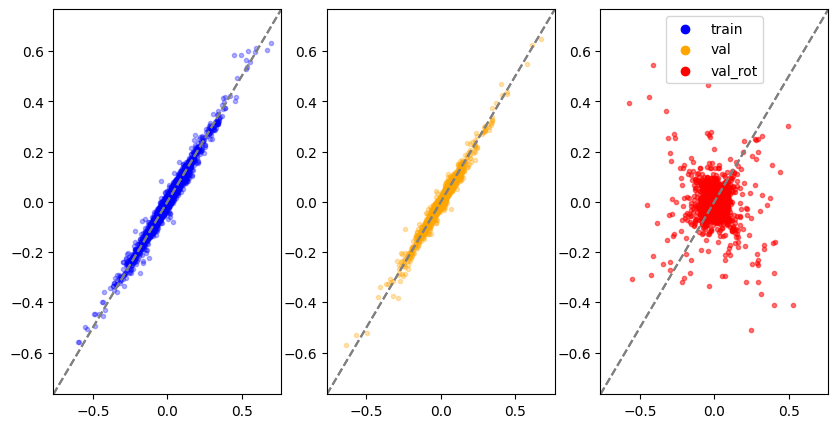

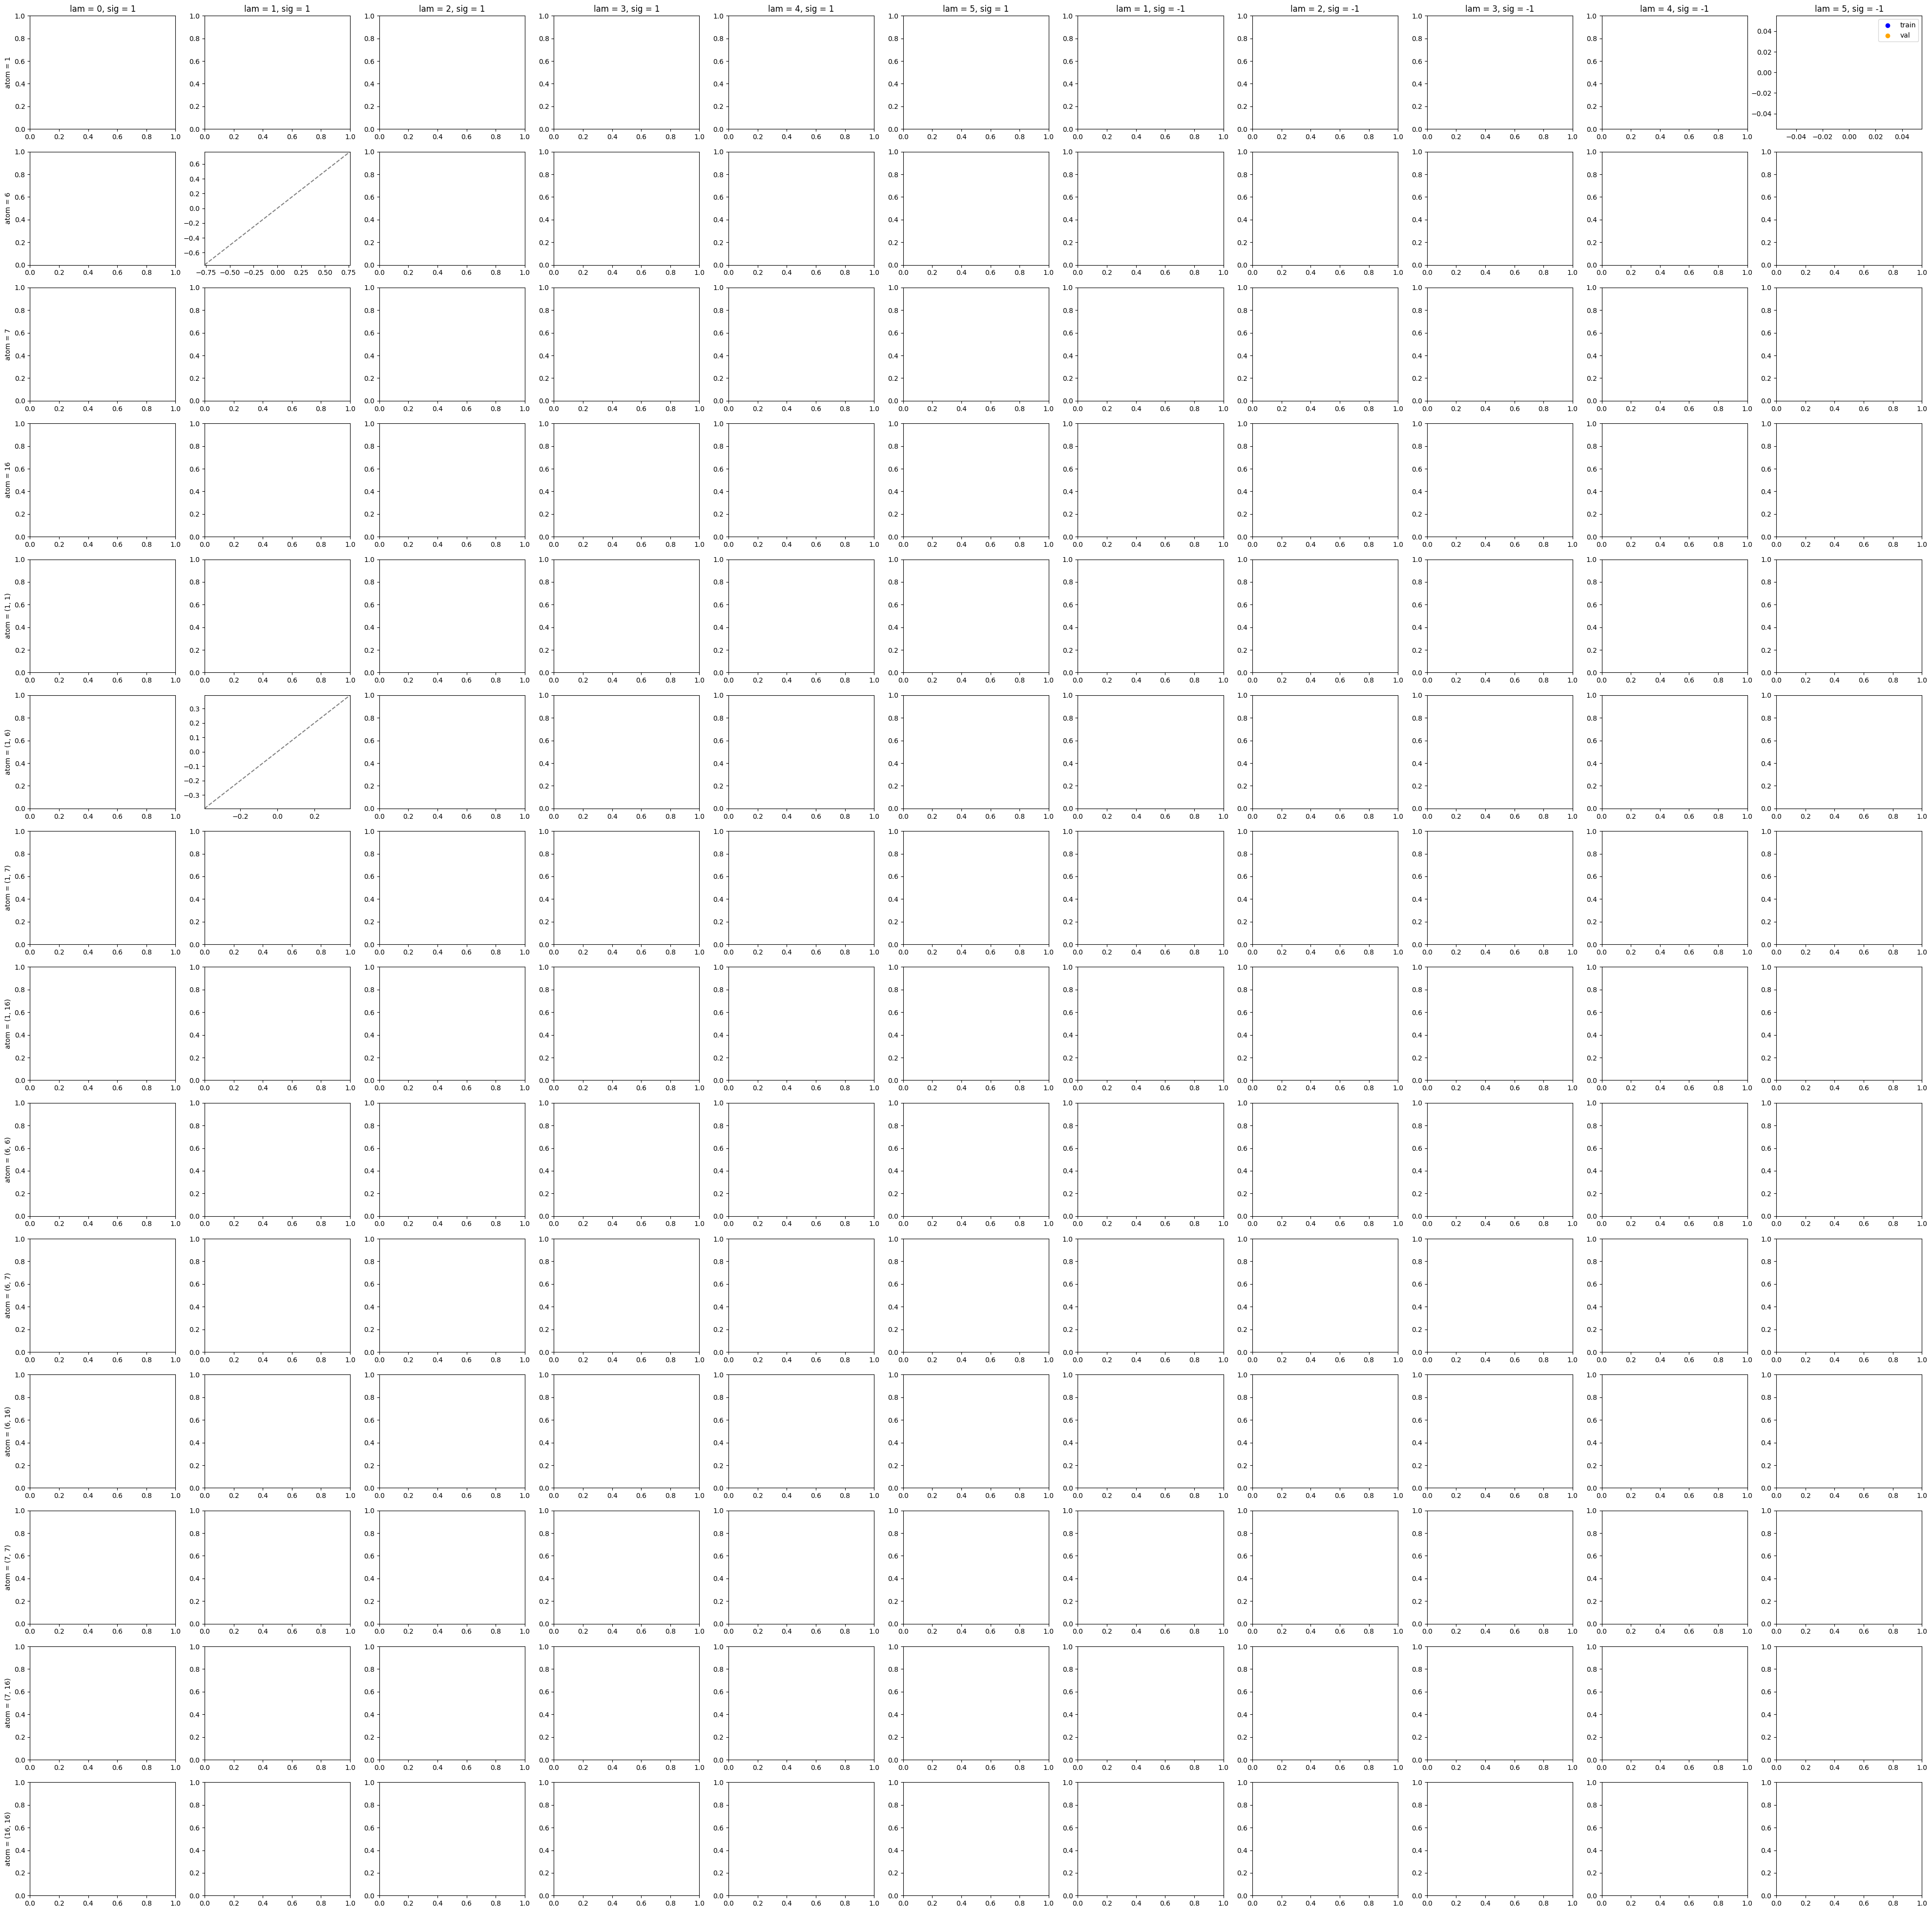

In [56]:
# Setup plots
row_idxs = {}
flat_idx = 0
for alpha in atomic_types:
    row_idxs[alpha] = flat_idx
    flat_idx += 1

for alpha_1 in atomic_types:
    for alpha_2 in atomic_types:
        if alpha_1 <= alpha_2:
            row_idxs[(alpha_1, alpha_2)] = flat_idx
            flat_idx += 1

fig_1, axes_1 = plt.subplots(1, 3, figsize=(10, 5))
fig_2, axes_2 = plt.subplots(len(row_idxs), (Lmax + 1) * 2 - 1, figsize=(50, 50))

# Plot nodes
ax_1_lim = 0
if model.in_keys_node is not None:
    for key in train_targets_node.keys:
        ax_2 = axes_2[
            row_idxs[key["center_type"]],
            key["o3_lambda"] + (0 if key["o3_sigma"] == 1 else Lmax),
        ]

        train_x = train_targets_node[key].values.flatten().detach().numpy()
        train_y = train_predictions_node[key].values.flatten().detach().numpy()
        val_x = val_targets_node[key].values.flatten().detach().numpy()
        val_y = val_predictions_node[key].values.flatten().detach().numpy()
        val_rot_x = val_targets_node_rot[key].values.flatten().detach().numpy()
        val_rot_y = val_predictions_node_rot[key].values.flatten().detach().numpy()
        # Set axes limits
        ax_lim = np.max(np.abs(np.concatenate([train_x, val_x, train_y, val_y]))) * 1.1
        ax_1_lim = max(ax_1_lim, ax_lim)
        ax_2.set_xlim([-ax_lim, ax_lim])
        ax_2.set_ylim([-ax_lim, ax_lim])
        # for ax in [ax_1, ax_2]:
        axes_1[0].scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
        axes_1[1].scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
        axes_1[2].scatter(val_rot_x, val_rot_y, alpha=0.3, marker=".", c="red")
        [ax_1.axline([0, 0], slope=1, linestyle="--", c="gray") for ax_1 in axes_1]
        # ax_2.scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
        # ax_2.scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
        ax_2.axline([0, 0], slope=1, linestyle="--", c="gray")

# Plot edges
if model.in_keys_edge is not None:
    for key in train_targets_edge.keys:
        ax_2 = axes_2[
            row_idxs[(key["first_atom_type"], key["second_atom_type"])],
            key["o3_lambda"] + (0 if key["o3_sigma"] == 1 else Lmax),
        ]

        train_x = train_targets_edge[key].values.flatten().detach().numpy()
        train_y = train_predictions_edge[key].values.flatten().detach().numpy()
        val_x = val_targets_edge[key].values.flatten().detach().numpy()
        val_y = val_predictions_edge[key].values.flatten().detach().numpy()
        ax_lim = np.max(np.abs(np.concatenate([train_x, val_x, train_y, val_y]))) * 1.1
        ax_1_lim = max(ax_1_lim, ax_lim)
        ax_2.set_xlim([-ax_lim, ax_lim])
        ax_2.set_ylim([-ax_lim, ax_lim])
        # for ax in [ax_1, ax_2]:
        axes_1[0].scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
        axes_1[1].scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
        axes_1[2].scatter(val_rot_x, val_rot_y, alpha=0.3, marker=".", c="red")
        [ax_1.axline([0, 0], slope=1, linestyle="--", c="gray") for ax_1 in axes_1]
        # ax_2.scatter(train_x, train_y, alpha=0.3, marker=".", c="blue")
        # ax_2.scatter(val_x, val_y, alpha=0.3, marker=".", c="orange")
        ax_2.axline([0, 0], slope=1, linestyle="--", c="gray")

# Format ax_1
[ax_1.set_xlim([-ax_1_lim, ax_1_lim]) for ax_1 in axes_1]
[ax_1.set_ylim([-ax_1_lim, ax_1_lim]) for ax_1 in axes_1]
axes_1[-1].scatter([None], [None], label="train", c="blue")
axes_1[-1].scatter([None], [None], label="val", c="orange")
axes_1[-1].scatter([None], [None], label="val_rot", c="red")
axes_1[-1].legend()

# Format axes_2
axes_2[0, -1].scatter([None], [None], label="train", c="blue")
axes_2[0, -1].scatter([None], [None], label="val", c="orange")
axes_2[0, -1].legend()
for key, idx in row_idxs.items():
    axes_2[idx, 0].set_ylabel(f"atom = {key}")
[
    ax.set_title(f"lam = {lam}, sig = {sig}")
    for lam, sig, ax in zip(
        list(range(Lmax + 1)) + list(range(1, Lmax + 1)),
        ([1] * (Lmax + 1)) + ([-1] * (Lmax + 1)),
        axes_2[0, :],
    )
];

In [14]:
# Equivariance evaluation
model.eval()

systems_train = [train_dataset.get_sample(A).systems for A in train_id]
systems_val = [val_dataset.get_sample(A).systems for A in val_id]

# Get targets
if model.in_keys_node is not None:
    train_targets_node = mts.join(
        [train_dataset.get_sample(A).targets_node for A in train_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_node = mts.join(
        [val_dataset.get_sample(A).targets_node for A in val_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )

if model.in_keys_edge is not None:
    train_targets_edge = mts.join(
        [train_dataset.get_sample(A).targets_edge for A in train_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    val_targets_edge = mts.join(
        [val_dataset.get_sample(A).targets_edge for A in val_id],
        "samples",
        remove_tensor_name=True,
        different_keys="union",
    )
    train_targets_edge = mts.sort(train_targets_edge, "samples")
    val_targets_edge = mts.sort(val_targets_edge, "samples")

In [ ]:
# Augment systems and targets with rotations around Z
losses = {"train_node": [], "train_edge": [], "val_node": [], "val_edge": []}
Z = np.linspace(0, 2 * np.pi, 7)

tmp_systems_train = []
tmp_systems_val = []

for z in Z:
    # Define transformations
    rotations = [Rotation.from_euler("ZYZ", [0, 0, z]) for _ in systems_train]
    inversions = [1 for _ in systems_train]

    # TRAIN: Apply rotational augmentation - node
    if model.in_keys_node is not None:
        systems_train_, train_targets_node_ = rotational_augmenter.apply_augmentations(
            systems_train,
            {"mtt::target_node": train_targets_node},
            rotations,
            inversions,
        )
        train_targets_node_ = train_targets_node_["mtt::target_node"]

    # TRAIN: Apply rotational augmentation - edge
    if model.in_keys_edge is not None:
        systems_train_, train_targets_edge_ = rotational_augmenter.apply_augmentations(
            systems_train,
            {"mtt::target_edge": train_targets_edge},
            rotations,
            inversions,
        )
        train_targets_edge_ = train_targets_edge_["mtt::target_edge"]

    tmp_systems_train.append(systems_train_[0])

    # TRAIN: Get predictions
    train_predictions_node_, train_predictions_edge_ = model(
        systems_train_,
        train_id,
    )
    assert mts.equal_metadata(train_targets_node, train_targets_node_)
    assert mts.equal_metadata(train_targets_edge, train_targets_edge_)
    if z not in [0, 2 * np.pi]:  # TensorMaps should not be equal
        assert not mts.allclose(train_targets_node, train_targets_node_)
        assert not mts.allclose(train_targets_edge, train_targets_edge_)
    assert mts.equal_metadata(train_predictions_node_, train_targets_node_)
    assert mts.equal_metadata(train_predictions_edge_, train_targets_edge_)

    # VAL: Apply rotational augmentation - node
    if model.in_keys_node is not None:
        systems_val_, val_targets_node_ = rotational_augmenter.apply_augmentations(
            systems_val,
            {"mtt::target_node": val_targets_node},
            rotations,
            inversions,
        )
        val_targets_node_ = val_targets_node_["mtt::target_node"]

    # VAL: Apply rotational augmentation - edge
    if model.in_keys_edge is not None:
        systems_val_, val_targets_edge_ = rotational_augmenter.apply_augmentations(
            systems_val,
            {"mtt::target_edge": val_targets_edge},
            rotations,
            inversions,
        )
        val_targets_edge_ = val_targets_edge_["mtt::target_edge"]

    tmp_systems_val.append(systems_val_[0])

    # VAL: Get predictions
    val_predictions_node_, val_predictions_edge_ = model(
        systems_val_,
        val_id,
    )
    assert mts.equal_metadata(val_targets_node, val_targets_node_)
    assert mts.equal_metadata(val_targets_edge, val_targets_edge_)
    if z not in [0, 2 * np.pi]:  # TensorMaps should not be equal
        assert not mts.allclose(val_targets_node, val_targets_node_)
        assert not mts.allclose(val_targets_edge, val_targets_edge_)
    assert mts.equal_metadata(val_predictions_node_, val_targets_node_)
    assert mts.equal_metadata(val_predictions_edge_, val_targets_edge_)

    # Compute losses and store
    losses["train_node"].append(
        elearn.l2loss(train_predictions_node_, train_targets_node_)
        / len(systems_train_)
    )
    losses["train_edge"].append(
        elearn.l2loss(train_predictions_edge_, train_targets_edge_)
        / len(systems_train_)
    )
    losses["val_node"].append(
        elearn.l2loss(val_predictions_node_, val_targets_node_) / len(systems_val_)
    )
    losses["val_edge"].append(
        elearn.l2loss(val_predictions_edge_, val_targets_edge_) / len(systems_val_)
    )

In [ ]:
# Plot loss as a function of Z rotation
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 5))
axes[0].plot(
    Z, [i.item() for i in losses["train_node"]], label="train_node", marker="."
)
axes[0].plot(Z, [i.item() for i in losses["val_node"]], label="val_node", marker=".")
axes[1].plot(
    Z, [i.item() for i in losses["train_edge"]], label="train_edge", marker="."
)
axes[1].plot(Z, [i.item() for i in losses["val_edge"]], label="val_edge", marker=".")
[ax.legend() for ax in axes]
[ax.set_xlabel("Rotation around Z / rad") for ax in axes]
[ax.set_ylabel("Loss per structure") for ax in axes];
# [ax.set_yscale("log") for ax in axes];

In [ ]:
import ase
import chemiscope


tmp_frames = [
    ase.Atoms(
        system.types,
        system.positions,
    )
    for system in tmp_systems_train
]
chemiscope.show(tmp_frames, mode="structure")